In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Warning
# sklearn>=1.6 raises a FutureWarning for an incomming deprecation in its own cross-validation function. 
# Results are not impacted, but the deprecation-warning floods the cell outputs, so we surpress it.

import matplotlib.pyplot as plt
import seaborn as sns
import style
style.set_style()


# Data loading

We first define the input space for both inputs $S_1$ and $S_2$

In [2]:
extends_s1 = (40.0, 100.0)
extends_s2 = (15.0, 75.0)

Then, we load in the data from a csv file with different reservoir input-output combinations on each row, corresponding to ${(u_i), (x_i)}$.
We drop columns with irrelevant meta-data, and rename the respective input columns to `S1` and `S2` for easier referencing.
Then, we normalize the input ranges (using the previously defined input space), and the reservoir feature outputs.

In [3]:
dropped_columns = ['author', 'exp_code', 'type', 'exp_date', 'measurement_date', 'measurement_time', 'sample', 'flowrate',
                   'TKIFKI', 'TTMHPRL',
                   'T', 'pH', 'SSVRWWSDDEWRW', 
                   'CCF(pS)WRCRC', 'IYPFVEPI'
                   ]

df_data_S = pd.read_csv("../data/RC_S1_S2.csv", index_col=0).drop(columns=dropped_columns).rename(columns = {
                        'AVNIPFKVHLRCKAAFC': 'S1',
                        'CCFSWRCRC': 'S2'
                        })
# Seperate dataset inputs and outputs
U_chem = df_data_S[['S1','S2']] # inputs
X_chem = df_data_S.drop(columns=['S1', 'S2']) # outputs

scaler_s1_s2 = preprocessing.MinMaxScaler().fit(pd.DataFrame({'S1': extends_s1, 'S2': extends_s2}))
U = scaler_s1_s2.transform(U_chem)
X = preprocessing.StandardScaler().fit_transform(X_chem)


# Task definitions

We now define the XOR classification task on the normalized input space, to obtain the true outputs $y_{xor}$ corresponding to each input $u_i$.

We also define a grid-version of the XOR task for background visualization.

In [6]:
y_xor = np.logical_xor(U[:,0] < 0.5, U[:,1] < 0.5)


N_POINTS = 1000
EXTENDS = (-0.1, 1.1)
xs, ys = np.meshgrid(np.linspace(*EXTENDS, N_POINTS), np.linspace(*EXTENDS, N_POINTS))

z_xor = np.logical_xor(xs < 0.5, ys < 0.5)


Next, we define the training algorithm for the linear readout layer.
For this, we use Scikit-learn's Support Vector Classifier with a `linear` kernel.
We fit this classifier to the reservoir outputs and the true XOR outputs, to obtain a set of linear weights (`reg.fit(...))
We then apply those linear weights to obtain the predicted XOR outputs, using `reg.predict(X)`.
Then, we visualize the predictions of the reservoir with the true values (and thus desired output) as a background using the Matplotlib library.

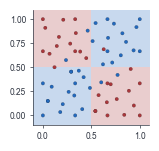

In [7]:
from sklearn import svm

reg = svm.SVC(max_iter=10_000, C=1, tol=1e-4, kernel='linear')

reg.fit(X, y_xor)
y_predict = reg.predict(X)

fig, ax = plt.subplots(figsize=(1.5,1.5))

cmap = sns.color_palette("blend:#BF616A,#EBCB8B,#8FBCBB", as_cmap=True, n_colors=10)
ax.scatter(
    *U.T,
    s=(2.5**2),
    c=y_predict,
    lw=0.1,
    ec="black",
    zorder=10,
    cmap=sns.color_palette("vlag", as_cmap=True),
    norm=plt.Normalize(0.0, 1.0),
)
ax.imshow(
    z_xor,
    origin="lower",
    aspect="auto",
    interpolation="none",
    extent=(*EXTENDS, *EXTENDS),
    alpha=0.25,
    cmap=sns.color_palette("vlag", as_cmap=True),
)
plt.show()

To verify that we are not overfitting the linear readout layer, we perform a stratified leave-N-out cross-validation, performed using another function from Scikit-learn.
We again define our training algorithm, but now we also define the scoring metric, using the Matthew's Correlation Coefficient (also known as the $\Phi$ coefficient), which returns values between -1 and +1.
Finally we transform this $\Phi$ coefficient to the $\Phi$ accuracy with values between 0 and +1. 
We also calculate the standard-error over the accuracies obtained in the cross-validation, by normalizing the standard deviations over all cross-validation splits and repeats by the square root of the number of splits/repeats performed:
$SE = \sigma / \sqrt{N_{repeats}}$

In [9]:
from sklearn import svm
from sklearn import metrics, model_selection

N_inputs = U.shape[0]
n_repeats = 10

reg = svm.SVC(max_iter=10_000, C=1, tol=1e-4, kernel='linear')
scores = model_selection.cross_validate(
    reg, X, y_xor,
    scoring = metrics.make_scorer(metrics.matthews_corrcoef),
    cv = model_selection.RepeatedStratifiedKFold(
        n_splits=N_inputs//5, n_repeats=n_repeats,
    )
)

test_score = (scores['test_score'].mean() + 1)/2
test_score_std = ((scores['test_score']+1)/2).std()/np.sqrt(len(scores['test_score']))

print(test_score, test_score_std)

0.7279832207214756 0.01719458229876889
